In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from notebooks.imports import *

In [2]:
import warnings
# suppress warnings
warnings.filterwarnings("ignore")

# Basics
import arviz as az  # Visualization
import pytensor  # Graph-based tensor library
import hssm
from ssms.basic_simulators.simulator import simulator
import ssms
from pptx import Presentation
from pptx.util import Inches
# import ssms.basic_simulators # Model simulators
import hddm_wfpt
import bambi as bmb

# Setting float precision in pytensor
pytensor.config.floatX = "float32"

import jax
jax.config.update("jax_enable_x64", False)

import src.utils.setup_figures as figures
import src.utils.basic as utils


jax.devices()

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
2024-11-14 22:20:37.836928: W external/xla/xla/service/platform_util.cc:206] unable to create StreamExecutor for CUDA:0: : CUDA_ERROR_OUT_OF_MEMORY: out of memory


[CudaDevice(id=1)]

In [4]:
from config import dir_config, main_config

base_data_dir = Path(dir_config.data.base)
raw_dir = Path(dir_config.data.raw)
processed_dir = Path(dir_config.data.processed)

data = pd.read_csv(Path(processed_dir, "processed_data60accu_allowed.csv"), index_col=None)
processed_metadata = pd.read_csv(Path(processed_dir, "processed_metadata_60accu_allowed.csv"), index_col=None)

# exclude the following subjects where categorization score is more than 2
reject_subs = processed_metadata.loc[processed_metadata["categorization_score"] > 2]['subject_id']
processed_metadata = processed_metadata.loc[~processed_metadata["subject_id"].isin(reject_subs)]
processed_data = data.loc[~data["subject"].isin(reject_subs)]


## Model

In [5]:
processed_data.head()                                           

,subject,medication,prior,prior_direction,prior_color,color,coherence,target,is_valid,outcome,choice,reaction_time,session_name,signed_coherence
0,CG,off,rl,left,red,1,100.0,1,True,True,1,626.976669,Brady_CG_OFFmeds_rl.mat,100.0
1,CG,off,rl,left,red,-1,0.0,1,True,False,-1,945.801775,Brady_CG_OFFmeds_rl.mat,0.0
2,CG,off,rl,left,red,-1,0.0,-1,True,False,1,964.249405,Brady_CG_OFFmeds_rl.mat,-0.0
3,CG,off,rl,left,red,-1,100.0,-1,True,True,-1,671.215080,Brady_CG_OFFmeds_rl.mat,-100.0
4,CG,off,rl,left,red,-1,0.0,1,True,True,1,1046.959465,Brady_CG_OFFmeds_rl.mat,0.0


### Loading Dataset

processed_data  
&ensp;&ensp;color: &ensp;&ensp;&ensp;&ensp;&ensp;{prior: 1, equal: -1}  
&ensp;&ensp;direction: &ensp;&ensp;{prior: 1, equal: -1}

In [6]:
data = pd.DataFrame(
    {
        "rt": processed_data["reaction_time"]/1000,
        "response": processed_data["choice"],
        "stimulus": processed_data["signed_coherence"]/100,
        "color": processed_data["color"].astype("category"),
        "treatment": processed_data["medication"].replace({"off": 0, "on": 1}).astype("category"),
        "subject": processed_data["subject"].astype("category"),
    }
)

### Weibull Model

In [ ]:
def get_weibull_model(data):
    weibull_model = hssm.HSSM(
        data = data,
        model = "weibull",
        include = [
            {
                "name": "v",
                "prior": {
                    # "Intercept": {"name": "Uniform", "lower": -3.0, "upper": 3.0},
                    "stimulus":  {"name": "Uniform", "lower": -3.0, "upper": 3.0},
                    "treatment":  {"name": "Uniform", "lower": -3.0, "upper": 3.0},
                    "subject":  {"name": "Uniform", "lower": -3.0, "upper": 3.0},
                },
                # "formula": "v ~ (1|stimulus) + C(treatment) + C(color)", # random effect for stimulus, fixed effect for treatment and subject
                "formula": "v ~ (stimulus|C(treatment)*C(color)*C(subject))", # how does slope and offset changes with treatment and color
                "link": "identity",
                "bounds": (-3.0, 3.0),
            },
                        
            {
                "name": "a",
                # "prior": {"Intercept": {"name": "Uniform", "lower": 0.5, "upper": 3.0},},
                "formula": "a ~ (1|C(treatment)*C(color)*C(subject))",
            },
            {
                "name": "z",
                # "prior": {"Intercept": {"name": "Uniform", "lower": 0.1, "upper": 0.9},},
                "formula": "z ~ (1|C(subject))",
            },
            {
                "name": "t",
                # "prior": {"Intercept": {"name": "Uniform", "lower": 0.1, "upper": 0.9},}, 
                "formula": "t ~ (1|C(subject))",
            },
            {
                "name": "alpha",
                # "prior": {"Intercept": {"name": "Uniform", "lower": 0.1, "upper": 0.9},},
                "formula": "alpha ~ (1|C(subject))",
            },
            {
                "name": "beta",
                # "prior": {"Intercept": {"name": "Uniform", "lower": 0.1, "upper": 0.9},}, 
                "formula": "beta ~ (1|C(subject))",
            },
        ],
    )
    return weibull_model
weibull_full_model = get_weibull_model(data)


Model initialized successfully.


In [1]:
weibull_full_model.summary()

NameError: name 'weibull_full_model' is not defined

Model initialized successfully.
Using default initvals. 



sample: 100%|██████████| 1000/1000 [02:34<00:00,  6.49it/s, 31 steps of size 2.81e-02. acc. prob=0.82] 
We recommend running at least 4 chains for robust computation of convergence diagnostics
100%|██████████| 1000/1000 [00:01<00:00, 618.84it/s]


array([[<Axes: title={'center': 'a_Intercept'}>,
        <Axes: title={'center': 'a_Intercept'}>],
       [<Axes: title={'center': 'a_C(treatment)'}>,
        <Axes: title={'center': 'a_C(treatment)'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'v_1|stimulus_sigma'}>,
        <Axes: title={'center': 'v_1|stimulus_sigma'}>],
       [<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>],
       [<Axes: title={'center': 'v_C(color)'}>,
        <Axes: title={'center': 'v_C(color)'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'v_1|stimulus'}>,
        <Axes: title={'center': 'v_1|stimulus'}>],
       [<Axes: title={'center': 'a_C(color)'}>,
        <Axes: title={'center': 'a_C(color)'}>],
       [<Axes: title={'center': 'v_1|stimulus_offset'}>,
        <Axes: title={'center': 'v_1|stimulus_offset'}>],
       [<Axes: title={'center'

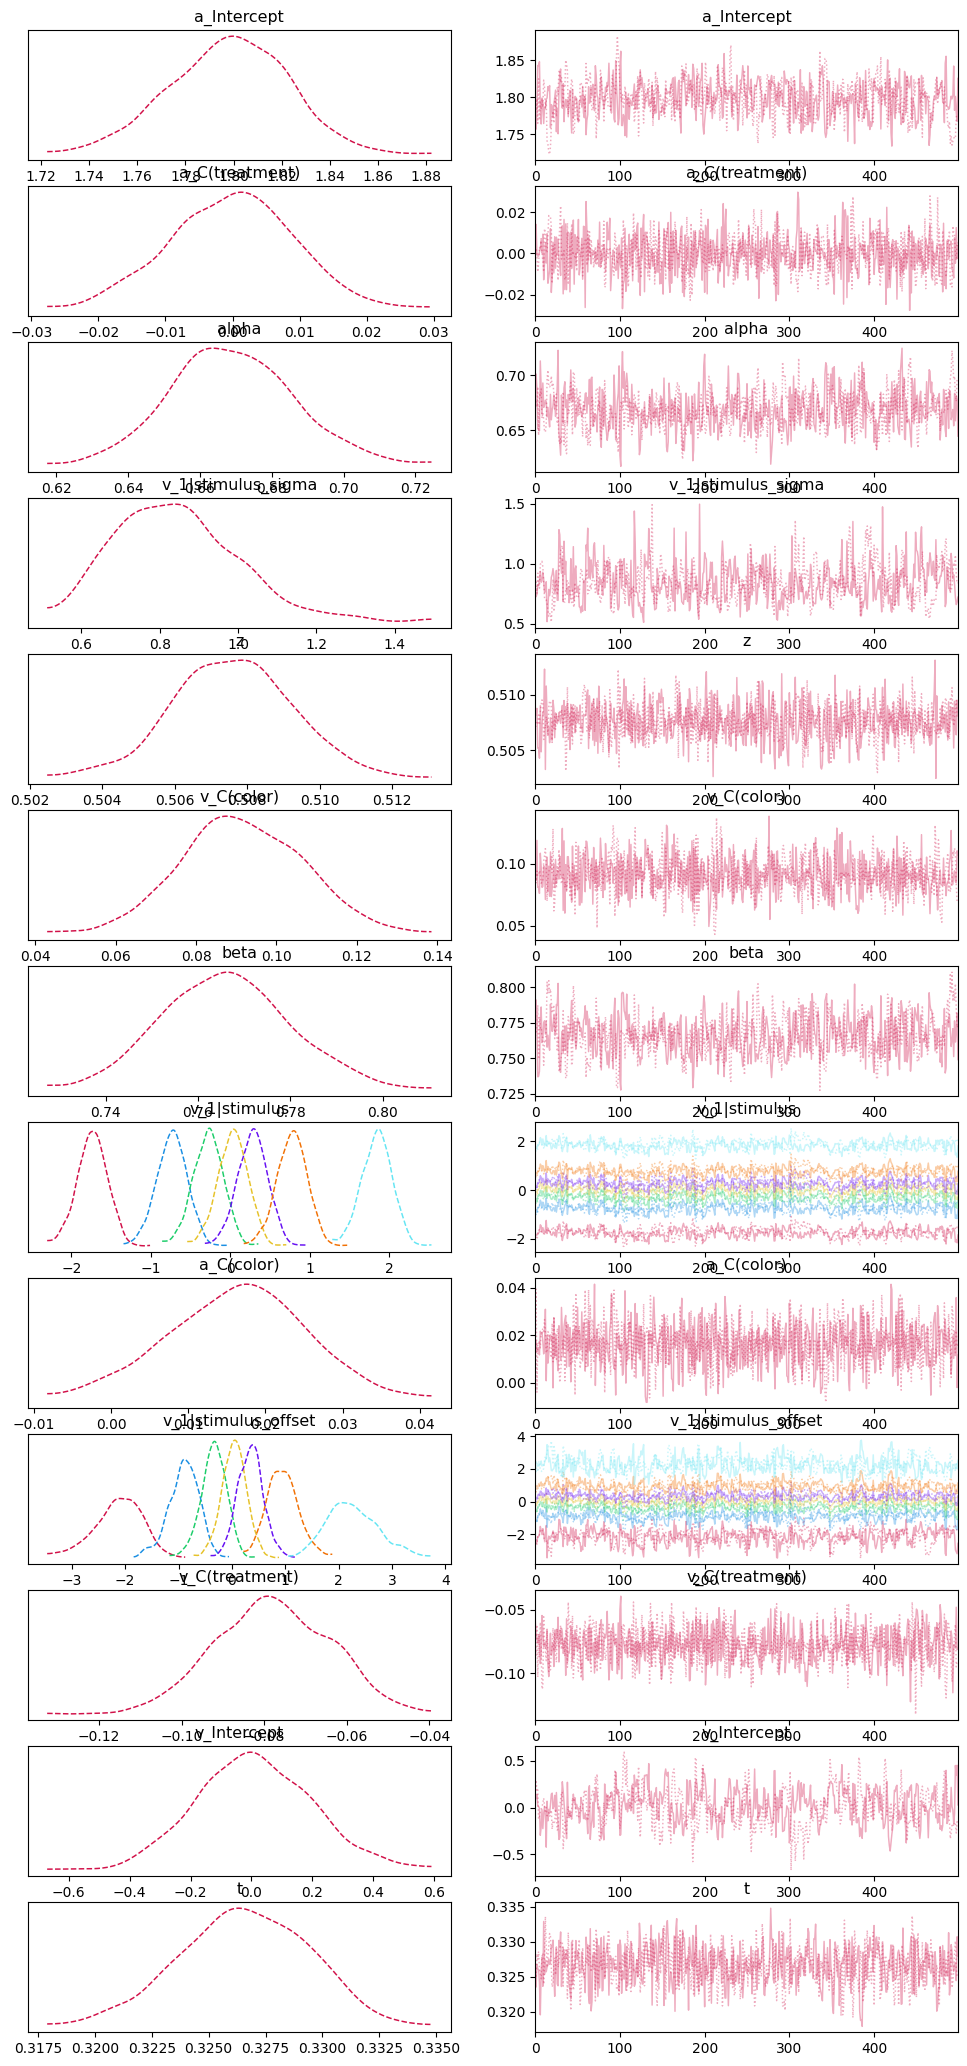

In [11]:
weibull_full_model = get_weibull_model(data)
idata_weibull_full_model = weibull_full_model.sample(sampler="nuts_numpyro", chains=2, cores=4, draws=500, tune=500)#, target_accept=0.95)

az.plot_trace(idata_weibull_full_model, combined=True, compact=True)

## Model fits

#### Utils functions

In [38]:
def plot_ppt(model_idata, group_model: bool = False):
    prs = Presentation()
    slide_layout = prs.slide_layouts[5]
    if group_model:
        fig = az.plot_trace(model_idata, combined=True, compact=True)
        plt.savefig("model_trace.png")
        plt.close()
        slide = prs.slides.add_slide(slide_layout)
        title = slide.shapes.title
        title.text = "Group Model"
        slide = prs.slides.add_slide(slide_layout)
        slide.shapes.add_picture("model_trace.png", left=Inches(0.01), top=Inches(0.01), width=Inches(8))
    else:
        for subject in model_idata.keys():
            fig = az.plot_trace(model_idata[subject], combined=True, compact=True)
            plt.savefig("model_trace.png")
            plt.close()
            slide = prs.slides.add_slide(slide_layout)
            title = slide.shapes.title
            title.text = f"Subject: {subject}"
            slide = prs.slides.add_slide(slide_layout)
            slide.shapes.add_picture("model_trace.png", left=Inches(0.01), top=Inches(0.01), width=Inches(8))
    
    Path("model_trace.png").unlink()
    return prs
    
def get_simulated_data(model_name, model):
    model.find_MAP()
    params = {}
    for param in list(weibull_full_model.list_params):
        if param != "p_outlier":
            params[param] = weibull_full_model.map[param]

    simulated_data = hssm.simulate_data(model=model_name, theta=params, size=1)
    return simulated_data

#### Organize Data

In [ ]:
simulated_data = get_simulated_data(model_name='weibull', model=weibull_full_model)

observed_data = weibull_full_model.data.copy()
observed_data.rename(columns={'response': 'choice', 'stimulus': 'signed_coherence'}, inplace=True)
observed_data['signed_coherence'] = observed_data['signed_coherence'].values*100
simulated_data['signed_coherence'] = observed_data['signed_coherence'].values
simulated_data.rename(columns={'response': 'choice'}, inplace=True)
simulated_data['color'] = observed_data['color'].values
simulated_data['treatment'] = observed_data['treatment'].values
simulated_data['subject'] = observed_data['subject'].values

Output()

idx: 0, color: 1, treatment: 0
idx: 1, color: -1, treatment: 0
idx: 2, color: 1, treatment: 1
idx: 3, color: -1, treatment: 1


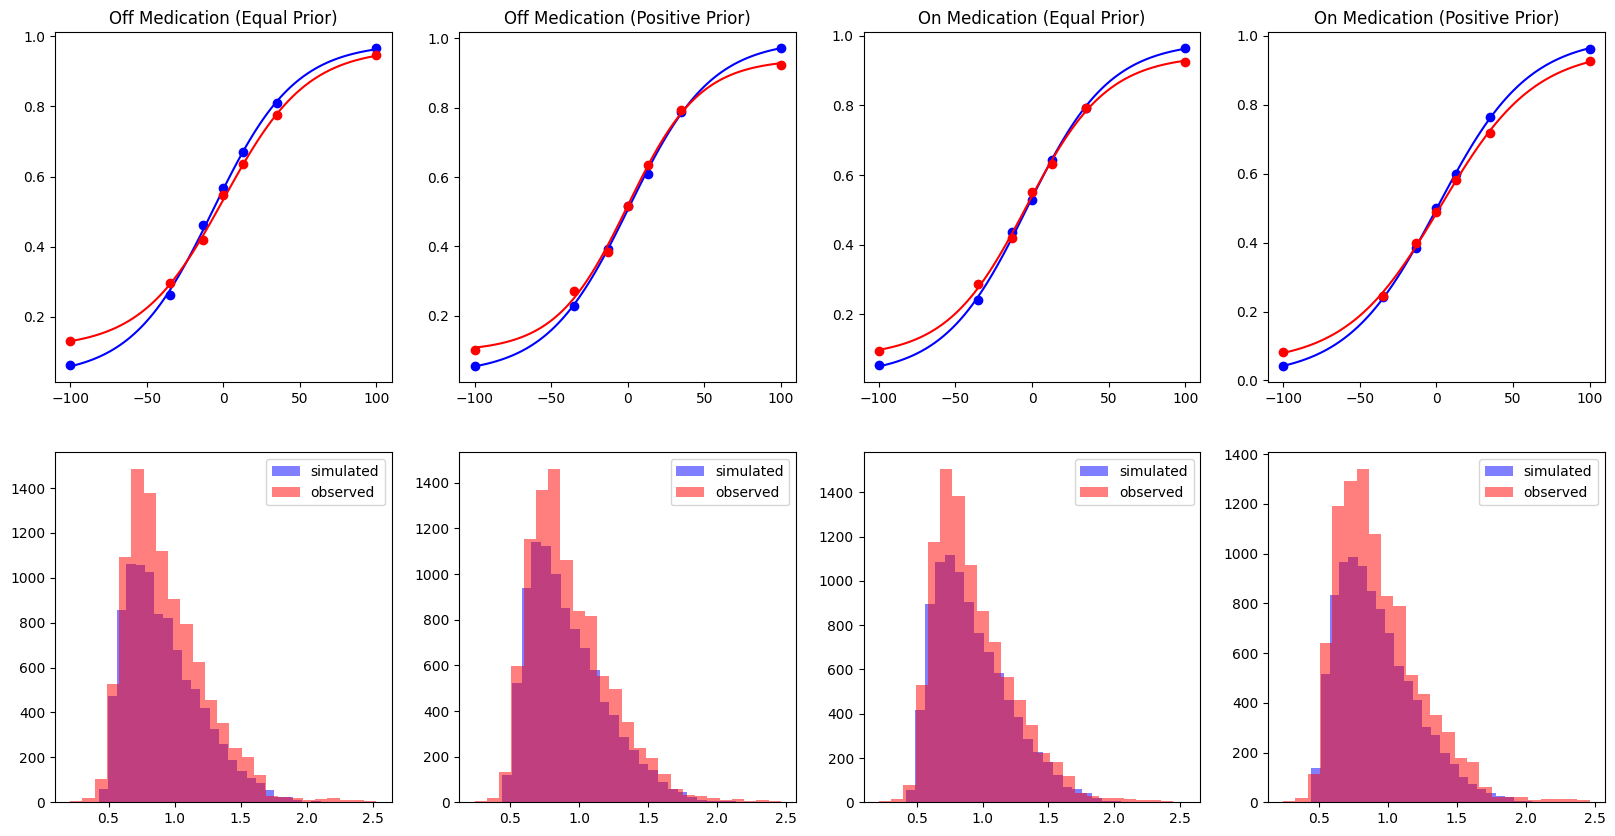

In [ ]:
treatments = observed_data['treatment'].unique()
colors = observed_data['color'].unique()
colors_treatments = [(treatment, color) for treatment in treatments for color in colors]

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for idx, (treatment, color) in enumerate(colors_treatments):
        print(f"idx: {idx}, color: {color}, treatment: {treatment}")
        
        subset_idx = np.where((observed_data['treatment'] == treatment) & (observed_data['color'] == color))[0]
        # plot psychometric function
        coh, pf, pf_model, x_hat, y_hat, _ = utils.get_psychometric_data(simulated_data.iloc[subset_idx])
        ax[0, idx].plot(coh, pf, 'o', color='blue')
        ax[0, idx].plot(x_hat, y_hat, color='blue')
        coh, pf, pf_model, x_hat, y_hat, _ = utils.get_psychometric_data(observed_data.iloc[subset_idx])
        ax[0, idx].plot(coh, pf, 'o', color='red')
        ax[0, idx].plot(x_hat, y_hat, color='red')    
        if idx == 0:
                ax[0, idx].set_title(f"Off Medication (Equal Prior)")
        elif idx == 1:
                ax[0, idx].set_title(f"Off Medication (Positive Prior)")   
        elif idx == 2:
                ax[0, idx].set_title(f"On Medication (Equal Prior)")
        else:
                ax[0, idx].set_title(f"On Medication (Positive Prior)")
        
        
        ax[1, idx].hist(simulated_data['rt'][subset_idx], bins=25, alpha=0.5, label='simulated', color='blue')
        ax[1, idx].hist(observed_data['rt'].iloc[subset_idx], bins=25, alpha=0.5, label='observed' , color='red')
        ax[1, idx].legend()

In [ ]:

with open(Path(processed_dir, "idata_weibull_full_data.pickle"), "wb") as f:
    pickle.dump(idata_weibull_full_model, f)
    
# with open(Path(processed_dir, "weibull_model_full_data.pickle"), "wb") as f:
#     pickle.dump(weibull_full_model, f)

AttributeError: Can't pickle local object 'make_jax_logp_ops.<locals>.LANLogpOp'